In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import torch
from PIL import Image
from torch import nn
from torch.nn import Linear, functional as F, Dropout
from torchvision import models, transforms
import os
import random
from torch.nn import L1Loss
from models.cnn2 import UnifiedClassificaionAndRegressionAgeModel
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from transformerfacetest_swin_basecontext_8head import get_age_transformer
from sklearn.metrics import mean_absolute_error


/home/ziye/anaconda3/envs/test4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ziye/anaconda3/envs/test4/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ziye/anaconda3/envs/test4/lib/python3.10/site-pack

In [2]:
seed = 3407
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True

cuda:0


In [4]:
A=Image.open('UTKFace/jpg/32_0_3_20170119200318588.jpg.chip.jpg')

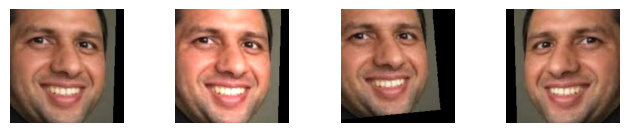

In [24]:
import torchvision.transforms as T
# 创建颜色抖动变换
jitter = T.ColorJitter(brightness=0.5, hue=0.3)
jitted_img = jitter(A)

# 创建随机仿射变换
CD = T.RandomAffine(
    degrees=10,
    translate=(0.1, 0.1),
    scale=(0.9, 1.1),
    shear=5
)
Er = CD(A)
gfgf=transforms.RandomHorizontalFlip()

dsg=gfgf(A)
# 显示原始图像
plt.subplot(1, 4, 1)
plt.imshow(A)
plt.axis('off')

# 显示颜色抖动后的图像
plt.subplot(1, 4, 2)
plt.imshow(jitted_img)
plt.axis('off')

# 显示随机仿射变换后的图像
plt.subplot(1, 4, 3)
plt.imshow(Er)
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(dsg)

# 调整子图之间的间距
plt.tight_layout()

plt.axis('off')

# 显示图像
plt.show()

In [5]:
TRAIN_CSV_PATH = './UTKFace/utkface_train.csv'
TEST_CSV_PATH = './UTKFace/utkface_test.csv'
IMAGE_PATH = './UTKFace/jpg'
df = pd.read_csv(TRAIN_CSV_PATH, index_col=0)
ages = df['age'].values
del df
ages = torch.tensor(ages, dtype=torch.float)
BATCH_SIZE = 1
min_age = 21
max_age = 60
age_interval = 3
NUM_CLASSES= int((max_age - min_age) / age_interval + 1)

In [6]:
mid_feature_size = 1024

In [7]:
model = get_age_transformer(device, 14, 3, 21, 60, mid_feature_size)
model_path='weights/transformer13-6head'
model_weights=os.path.join(model_path, "weights_72000_4.3778.pt")
model.load_state_dict(torch.load(model_weights))
model.to(device)
model.eval()
print('model loaded')


/home/ziye/anaconda3/envs/test4/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ziye/anaconda3/envs/test4/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model loaded


In [8]:
image=Image.open('fd.jpg')
seed = 3407
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
transform = transforms.Compose([
        transforms.RandomResizedCrop(224, (0.9, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1
        )], p=0.5),
        transforms.RandomApply([transforms.RandomAffine(
            degrees=10,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=5
        )], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5)
    ])

images = []
for i in range(10):
    transformed_image = transform(image.copy())  
    images.append(transformed_image)

image_stack = torch.stack(images)
print(image_stack.shape)
input=image_stack.unsqueeze(0)
print(input.shape)
input=input.to(device)

torch.Size([10, 3, 224, 224])
torch.Size([1, 10, 3, 224, 224])


In [9]:
with torch.no_grad():
    classification_logits, age_pred = model(input)
    # _, class_pred = torch.max(classification_logits, 1)

/home/ziye/test5/models/transformer.py:127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = nn.Softmax()(classification_logits)


In [10]:
print(age_pred)

tensor([54.1041], device='cuda:0')


In [11]:
from DataSet.UTKFaceDataset2 import UTKFaceDataset

test_dataset = UTKFaceDataset(csv_path=TEST_CSV_PATH,
                                img_dir=IMAGE_PATH,
                                transform=transform,copies=10)
test_loader=DataLoader(test_dataset,batch_size=1, pin_memory=True, shuffle=False,num_workers=4)

In [12]:
age_preds = []
ages=[]
class_preds=[]
age_class=[]
for idx,batch in enumerate(test_loader):
    input = batch['image'].to(device)
    classification_label = batch['classification_label']
    age = batch['age']
    with torch.no_grad():
        classification_logits, age_pred = model(input)
        _, class_pred = torch.max(classification_logits, 1) 
    
    age_preds.append(age_pred.cpu())
    ages.append(age)

/home/ziye/test5/models/transformer.py:127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = nn.Softmax()(classification_logits)


In [13]:
print(len(ages))

3287


In [14]:
import pandas as pd
import seaborn as sns

In [15]:
df_test=pd.read_csv('UTKFace/utkface_test.csv')
df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]
df_test['age']+=21
df_test['gender'] = df_test['file'].str.split('_').str[1]
df_test['race'] = df_test['file'].str.split('_').str[2]
df_test['gender'] = df_test['gender'].replace({'0': 'male', '1': 'female'})
df_test['race']=df_test['race'].replace({'0':'white','1':'black','2':'asian','3':'indian','4':'others'})
print(df_test.head())

                                    file  age  gender    race
0  40_1_3_20170119165539693.jpg.chip.jpg   40  female  indian
1  53_1_0_20170109133404907.jpg.chip.jpg   53  female   white
2  53_0_0_20170120223125364.jpg.chip.jpg   53    male   white
3  34_0_0_20170116232429422.jpg.chip.jpg   34    male   white
4  54_0_0_20170117191422211.jpg.chip.jpg   54    male   white


In [16]:
df=pd.DataFrame({'age':ages,'age_pred':age_preds})
df['age_pred']=df['age_pred'].apply(lambda x: x.cpu().detach().numpy()[0])
df['age']=df['age'].apply(lambda x: x.cpu().detach().numpy()[0])
# df['class']=df['class'].apply(lambda x: x.cpu().detach().numpy()[0])
# df['class_pred']=df['class_pred'].apply(lambda x: x.cpu().detach().numpy()[0])
df.head(20)

,age,age_pred
0,40,25.974785
1,53,31.360357
2,53,54.476841
3,34,36.867966
4,54,49.776321
5,26,31.519304
6,55,53.872383
7,25,26.032764
8,28,27.733591
9,34,35.052574


In [17]:
df_test['age_pred']=df['age_pred']
df_test.head(10)

,file,age,gender,race,age_pred
0,40_1_3_20170119165539693.jpg.chip.jpg,40,female,indian,25.974785
1,53_1_0_20170109133404907.jpg.chip.jpg,53,female,white,31.360357
2,53_0_0_20170120223125364.jpg.chip.jpg,53,male,white,54.476841
3,34_0_0_20170116232429422.jpg.chip.jpg,34,male,white,36.867966
4,54_0_0_20170117191422211.jpg.chip.jpg,54,male,white,49.776321
5,26_1_2_20170116181301976.jpg.chip.jpg,26,female,asian,31.519304
6,55_0_3_20170119183204846.jpg.chip.jpg,55,male,indian,53.872383
7,25_1_0_20170103180907920.jpg.chip.jpg,25,female,white,26.032764
8,28_0_0_20170117020857776.jpg.chip.jpg,28,male,white,27.733591
9,34_0_3_20170119200559340.jpg.chip.jpg,34,male,indian,35.052574


In [18]:
df['abs_age_diff'] = np.abs(df['age'] - df['age_pred'])
df_test['abs_age_diff']=df['abs_age_diff']
df_test.sample(10)

,file,age,gender,race,age_pred,abs_age_diff
446,27_0_4_20170117120226377.jpg.chip.jpg,27,male,others,28.183542,1.183542
3218,29_1_0_20170103175359824.jpg.chip.jpg,29,female,white,50.353661,21.353661
1988,30_0_1_20170117123915360.jpg.chip.jpg,30,male,black,33.064667,3.064667
3231,46_0_1_20170117182528088.jpg.chip.jpg,46,male,black,42.064384,3.935616
2592,26_1_3_20170104223022663.jpg.chip.jpg,26,female,indian,25.222271,0.777729
1622,25_0_0_20170117142949572.jpg.chip.jpg,25,male,white,26.556908,1.556908
524,34_0_0_20170119200810940.jpg.chip.jpg,34,male,white,37.319176,3.319176
1047,45_0_0_20170104212920676.jpg.chip.jpg,45,male,white,48.526993,3.526993
1119,30_0_0_20170117154851974.jpg.chip.jpg,30,male,white,28.329363,1.670637
2802,40_0_4_20170117194620611.jpg.chip.jpg,40,male,others,53.226799,13.226799


In [19]:
male_df = df_test[df_test['gender'] == 'male']
mae_male = male_df['abs_age_diff'].mean()

female_df = df_test[df_test['gender'] == 'female']
mae_female = female_df['abs_age_diff'].mean()

print(f"Male  MAE : {mae_male:.2f}")
print(f"Female  MAE : {mae_female:.2f}")

Male  MAE : 4.43
Female  MAE : 4.34


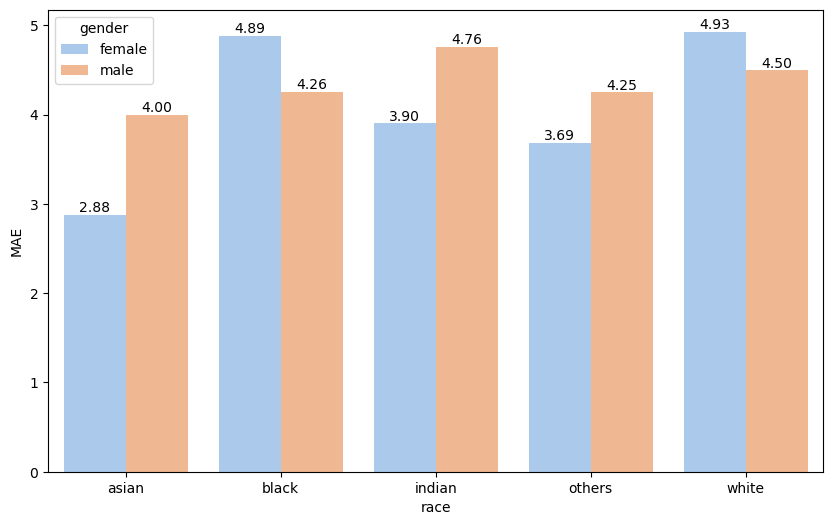

In [20]:
mae_by_race_gender = df_test.groupby(['race', 'gender'])['abs_age_diff'].mean().reset_index()
plt.figure(figsize=(10, 6))

ax=sns.barplot(x='race', y='abs_age_diff', hue='gender',data=mae_by_race_gender,palette='pastel')
plt.ylabel('MAE')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()


In [178]:
df_test.to_csv('test_pred.csv')

In [32]:
condition = (df_test['abs_age_diff'] > 0) & (df_test['abs_age_diff'] < 1)
count_condition = len(df_test[condition])

percentage = (count_condition / len(df_test)) * 100
print(percentage)

18.071189534529967


In [25]:
mae = mean_absolute_error(df['age'], df['age_pred'])

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 4.387546609519353


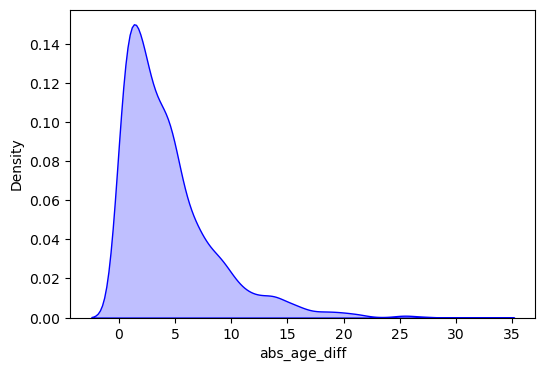

In [33]:
plt.figure(figsize=(6, 4))
sns.kdeplot(df_test['abs_age_diff'], fill=True, color='blue')
plt.show()

In [51]:
bin_size = 3
bins = np.arange(df_test['age'].min(), df_test['age'].max() + bin_size, bin_size)
df_test['age_group'] = pd.cut(df_test['age'], bins)

# 计算每个组的MAE
mae_by_age_group = df_test.groupby('age_group')['abs_age_diff'].mean()

print(mae_by_age_group)

age_group
(21, 24]    3.775368
(24, 27]    2.768461
(27, 30]    2.967502
(30, 33]    3.956945
(33, 36]    4.930650
(36, 39]    4.870900
(39, 42]    5.353894
(42, 45]    5.829763
(45, 48]    5.836163
(48, 51]    5.485508
(51, 54]    5.974408
(54, 57]    7.285373
(57, 60]    7.822420
Name: abs_age_diff, dtype: float64
